In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Pre-processing the Data**

This Python function preprocess_text is designed to clean and normalize text data. It takes a string input, converts it to lowercase, removes punctuation and non-alphabetic characters, tokenizes the text into words, removes common stop words (like 'and', 'the', etc.), lemmatizes the words (reduces them to their base or dictionary form), and then recombines the processed words back into a single string. The script then loads a CSV file containing a dataset into a pandas DataFrame, applies the preprocess_text function to the 'Question' column of the DataFrame to preprocess each question, and creates a new column 'Processed_Question' with the results. Finally, it displays the first few entries of both the original and processed questions for comparison.

In [4]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower() # Lower
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation and non-alphabetic characters
    tokens = word_tokenize(text) # Tokenise
    stop_words = set(stopwords.words('english')) # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer() # Lemmatize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)  # Rejoin tokens into a single string

# Load the data
file_path = '/content/Mental_Health_FAQ.csv'
data = pd.read_csv(file_path)

# Apply the preprocessing function to the question column
data['Processed_Question'] = data['Questions'].apply(preprocess_text)

# Show the processed questions
data[['Questions', 'Processed_Question']].head()


,Questions,Processed_Question
0,What does it mean to have a mental illness?,mean mental illness
1,Who does mental illness affect?,mental illness affect
2,What causes mental illness?,cause mental illness
3,What are some of the warning signs of mental i...,warning sign mental illness
4,Can people with mental illness recover?,people mental illness recover


Next block begins by importing the necessary Python libraries: pandas for data manipulation, Counter from the collections module for counting hashable objects, and matplotlib.pyplot along with WordCloud for data visualization. After that, the script prints out the size of the dataset using data.shape to give an idea of how many rows and columns are in the DataFrame data. It then prints out a sample of 5 random rows from the dataset using data.sample(5), which provides a quick snapshot of what kind of questions and answers are contained within the dataset, giving insight into the data's content and structure.

In [6]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud



# Explore the dataset
print("Sample questions and answers:\n", data.sample(5))

Sample questions and answers:
                                             Questions  \
95       How can I convince my kids not to use drugs?   
56              How do I apply for income assistance?   
71  I have thoughts of suicide, or someone I care ...   
96  What is the legal status (and evidence) of CBD...   
10  How can I find a mental health professional ri...   

                                              Answers  \
95  You can't. But you can influence their capacit...   
56  Provincial income assistance has three income ...   
71  If you need to talk to someone or you aren’t s...   
96  Cannabidiol or CBD is a naturally occurring co...   
10  Feeling comfortable with the professional you ...   

                              Processed_Question  
95                         convince kid use drug  
56                       apply income assistance  
71  thought suicide someone care talking suicide  
96                 legal status evidence cbd oil  
10   find mental health prof

**Understanding the Data**

This code block is designed to analyze and visualize certain aspects of the questions and answers from the dataset. It calculates the length distribution of the questions and answers by counting the number of words in each. These lengths are then plotted as histograms, with separate subplots for questions and answers to show their respective length distributions. A word cloud is also generated from the questions, providing a visual representation of the most frequent terms where more common words appear larger. Finally, the histograms and word cloud are displayed in a single figure with three subplots, neatly arranged and shown using matplotlib.

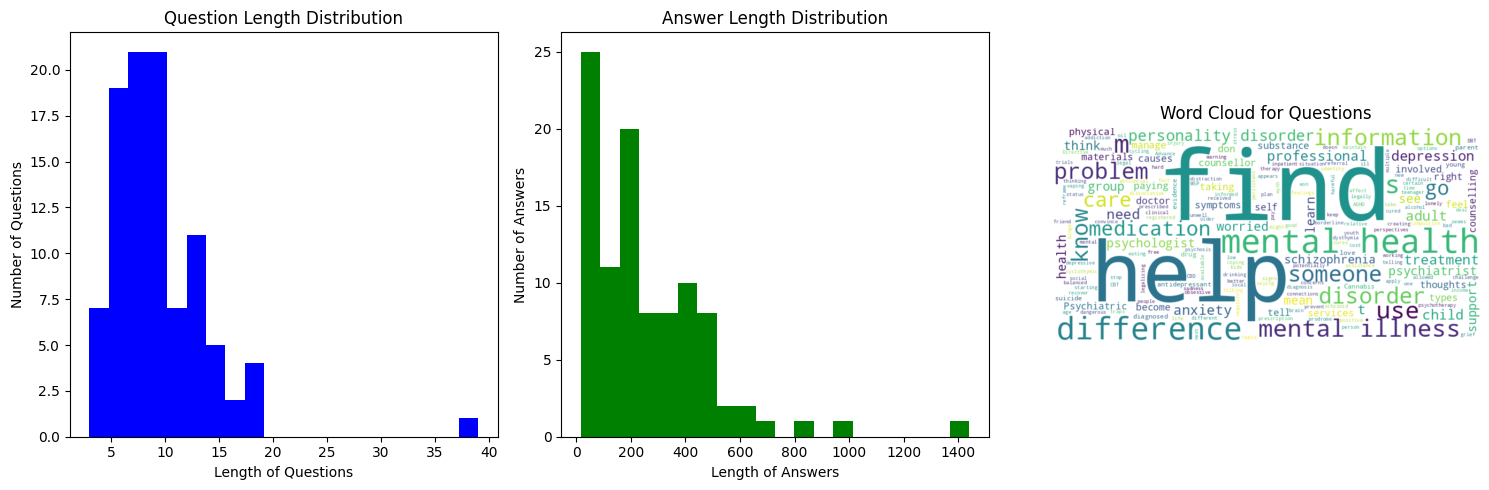

In [7]:
# Question length distribution
question_lengths = data['Questions'].apply(lambda x: len(x.split()))
answer_lengths = data['Answers'].apply(lambda x: len(x.split()))

# Common words in questions
all_words = ' '.join(data['Questions']).split()
common_words = Counter(all_words).most_common(10)

# Generate a word cloud for the questions
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(all_words))

# Plotting the distributions and word cloud
plt.figure(figsize=(15,5))

# Question lengths
plt.subplot(1, 3, 1)
plt.hist(question_lengths, bins=20, color='blue')
plt.title('Question Length Distribution')
plt.xlabel('Length of Questions')
plt.ylabel('Number of Questions')

# Answer lengths
plt.subplot(1, 3, 2)
plt.hist(answer_lengths, bins=20, color='green')
plt.title('Answer Length Distribution')
plt.xlabel('Length of Answers')
plt.ylabel('Number of Answers')

# Word Cloud
plt.subplot(1, 3, 3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')

plt.tight_layout()
plt.show()




**Intent Recognition, the goal is to understand what the user is asking and match this intent to the closest possible question from our FAQ data.**


This code block sets up a system to respond to user questions by finding the most similar question in a given dataset and providing the corresponding answer. It uses the TfidfVectorizer from Scikit-learn to convert the preprocessed questions into a TF-IDF (Term Frequency-Inverse Document Frequency) matrix, a numerical statistic that reflects how important a word is to a document in a collection. The get_response function takes a user's input, preprocesses it, vectorizes it, and computes cosine similarity scores with the existing TF-IDF matrix to find the closest match. The function then retrieves and returns the original form of the most similar question and its answer from the dataset. Finally, an example usage is shown where a user's question about dealing with anxiety is inputted, and the function finds and returns the most similar question from the dataset along with its answer.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer() # TF-IDF vectorizer
tfidf_matrix = vectorizer.fit_transform(data['Processed_Question']) # Vectorize the preprocessed questions

# Function to find the most similar question and retrieve the corresponding answer
def get_response(user_input, data, vectorizer, tfidf_matrix):

    preprocessed_input = preprocess_text(user_input)    # Preprocess the user's input

    user_input_vector = vectorizer.transform([preprocessed_input])  # Vectorize the user's input

    similarities = cosine_similarity(user_input_vector, tfidf_matrix)  # Compute the cosine similarity between the user's input and all preprocessed questions

    # Find the maximum similarity score and its index
    max_similarity_score = max(similarities[0])
    most_similar_question_index = similarities.argmax()

    # If the maximum similarity score is below the threshold, return a message indicating the limitation
    if max_similarity_score < 0.5:
        return None, "I am sorry, but I need to learn more to answer that question properly."

    most_similar_question_index = similarities.argmax()     # Find the index of the most similar question

    # Retrieve the most similar question and its answer
    similar_question = data.iloc[most_similar_question_index]['Questions']
    response = data.iloc[most_similar_question_index]['Answers']

    return similar_question, response


**Creating a mechanism to select the best response from the FAQ data based on the user's query.**

This block of code defines a chatbot function that interacts with users in a command-line interface. When started, the chatbot introduces itself and invites the user to ask questions. It remains in a loop, waiting for the user's input. When the user types a question, the chatbot processes the input using the get_response function previously defined, which finds the most similar question in the dataset and retrieves the corresponding answer using TF-IDF vectorization and cosine similarity. The chatbot then displays what it thinks the user is asking about, along with the relevant answer. If the user types 'quit', the chatbot exits the loop, effectively ending the session. The last line of code initiates the chatbot with the dataset, TF-IDF vectorizer, and precomputed TF-IDF matrix as inputs.

In [9]:
def chatbot(data, vectorizer, tfidf_matrix):
    print("Hello! I am here to help. Ask me any question, and I will try to find the best answer for you.")
    print("Type 'quit' to exit.")

    while True:
        user_input = input("You: ")
        if user_input.lower() == 'quit':
            break

        # Call get_response with all the necessary data
        similar_question, response = get_response(user_input, data, vectorizer, tfidf_matrix)

        print(f"MyResponse: {response}\n")



**Chatbot Testing and Evaluation**

The evaluate_chatbot function is designed to assess the performance of the chatbot by allowing users to interact with it and rate the relevance of its responses on a scale from 1 (not relevant) to 5 (highly relevant). During this evaluation mode, the user is prompted to enter questions, and after each response from the bot, they are asked to provide a score reflecting the quality of the answer. These scores are collected in a list, and once the user decides to exit the evaluation by typing 'quit', the function calculates the average score of the provided feedback, which serves as an indicator of the chatbot's overall performance. After the evaluation is complete, the average feedback score is printed out, giving a numerical value to the bot's efficacy in providing relevant answers.

In [ ]:
# Function to evaluate the chatbot by interacting with it and providing feedback on responses
def evaluate_chatbot(data, vectorizer, tfidf_matrix):
    # Start the evaluation mode
    print("Chatbot Evaluation Mode")
    print("Please provide feedback after each response on its relevance (1: not relevant, 5: highly relevant).")
    print("Type 'quit' to exit.")

    # List to store feedback scores
    feedback_scores = []

    # Loop for continuous interaction until the user decides to quit
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'quit':
            break

        # Get the response from the chatbot
        _, response = get_response(user_input, data, vectorizer, tfidf_matrix)
        print(f"Bot: {response}")

        # Ask for feedback on the response's relevance
        score = input("Please rate the response (1-5): ")
        # Record the feedback score if it's a valid integer
        try:
            feedback_scores.append(int(score))
        except ValueError:
            print("Invalid input. Skipping feedback for this response.")

    # Calculate the average feedback score if there are any feedback scores
    average_feedback = sum(feedback_scores) / len(feedback_scores) if feedback_scores else 0
    return average_feedback


average_feedback = evaluate_chatbot(data, vectorizer, tfidf_matrix)
print(f"Average feedback score: {average_feedback:.2f}")


Chatbot Evaluation Mode
Please provide feedback after each response on its relevance (1: not relevant, 5: highly relevant).
Type 'quit' to exit.
